# Compare Cost Functions

- cumulative cost 
- maximum (makespan)
- binary switch penalty
- greedy

In [1]:
import logging
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import numpy as np
import random
import seaborn as sns
import pandas as pd
import statistics as stat
import os
import yaml
import glob

# WHERE TO SAVE THE FIGURES?
save_loc = "/home/blr7rng/Documents/thesis/msc-thesis/j/cost_func_comp/"

# 1 Import and Read Result Data

## 1.1 Load Data

In [2]:
data = {"AGVs": [], "randseed": [], "delay": [], "horizon": [], "total_time": [], "improvement": [], "cost_func": []}

yaml_list_max      = glob.glob("max/*.yaml")
yaml_list_cum      = glob.glob("cumulative/*.yaml")
yaml_list_greedy   = glob.glob("greedy/*.yaml")
yaml_list_bp_10    = glob.glob("binary_penalty/*.yaml")
yaml_list_bp_5     = glob.glob("bp_kb_5/*.yaml")
yaml_list_bp_2     = glob.glob("bp_kb_2/*.yaml")
yaml_list_bp_1     = glob.glob("bp_kb_1/*.yaml")

yaml_list = yaml_list_max + yaml_list_cum + yaml_list_greedy + yaml_list_bp_1 + yaml_list_bp_2 + yaml_list_bp_5 + yaml_list_bp_10

# horizon_0_data = {"AGVs": [], "randseed": [], "delay": [], "total_time": []}

for file in yaml_list:
    
    split_filename = file.split("_")
    horizon = str(split_filename[-1].split(".")[0])
    delay = str(split_filename[-3])
    seed = str(split_filename[-5])
    AGVs = str(split_filename[-7])
    costfunc = str(split_filename[-9])
    
    with open(file, "r") as stream:
        yaml_data = yaml.safe_load(stream)
        cumulative_time = yaml_data["results"]["total time"]
        data["AGVs"].append(int(AGVs))
        data["randseed"].append(int(seed))
        data["delay"].append(int(delay))
        data["horizon"].append(int(horizon))
        data["total_time"].append(int(cumulative_time))
        data["improvement"].append(int(cumulative_time))
        data["cost_func"].append(str(costfunc))
        
# print(data)


In [3]:
df = pd.DataFrame(data, columns=["AGVs", "randseed", "delay", "horizon", "total_time", "improvement", "cost_func"])
# Get the 0 horizon data
df_0 = df[df.horizon == 0]

newdata = {"AGVs": [], "randseed": [], "delay": [], "horizon": [], "total_time": [], "improvement": [], "cost_func": []}

no_baseline_cnt = 0
baseline_cnt = 0
no_baseline_list = []

for index, row in df.iterrows():
    AGVs = row["AGVs"]
    randseed = row["randseed"]
    delay = row["delay"]
    horizon = row["horizon"]
    total_time = row["total_time"]
    cost_func = row["cost_func"]
    
    try: 
        baseline = df_0[(df_0.AGVs == AGVs) & (df_0.randseed == randseed) & (df_0.delay == delay)].iloc[0]
        baseline_time = baseline["total_time"]
        improvement = 100*(baseline_time-total_time)/baseline_time
        newdata["AGVs"].append(int(AGVs))
        newdata["randseed"].append(int(randseed))
        newdata["delay"].append(int(delay))
        newdata["horizon"].append(int(horizon))
        newdata["total_time"].append(int(total_time))
        newdata["improvement"].append(float(improvement))
        newdata["cost_func"].append(cost_func)
        baseline_cnt += 1
    except IndexError:
        # if no baseline (Horizon = 0) is found, do not add this data: cannot be compared
        no_baseline_cnt += 1
        no_baseline_str = str(AGVs) + " \t " + str(randseed) + " \t " + str(delay) + " \t " + str(horizon) + " \t " + str(cost_func)
        no_baseline_list.append(no_baseline_str)
        
print("Baselines found: {}".format(baseline_cnt))
print("No baseline count: {}".format(no_baseline_cnt))
print("List of baselines missing:")
print("AGVs \t seed \t delay \t horizon")
print("---------------------------------")
for row in no_baseline_list:
    print(row)
print("---------------------------------")

dfnew = pd.DataFrame(newdata, columns=["AGVs", "randseed", "delay", "horizon", "total_time", "improvement", "cost_func"])
# print(dfnew)

df_actual_data = dfnew[dfnew.horizon == 5]
print(df_actual_data)

Baselines found: 927
No baseline count: 0
List of baselines missing:
AGVs 	 seed 	 delay 	 horizon
---------------------------------
---------------------------------
     AGVs  randseed  delay  horizon  total_time  improvement cost_func
1      30         7     10        5        1425     0.627615       max
2      70         9     10        5        4087     0.993217       max
4      40        18     10        5        1886     0.632244       max
5      70        19     10        5        3776     0.000000       max
6      50        11     10        5        3243     0.399263       max
..    ...       ...    ...      ...         ...          ...       ...
922    70        10     10        5        3601     3.947719   penalty
923    60         9     10        5        3491     9.017462   penalty
924    40        11     10        5        2719     3.990113   penalty
925    40        15     10        5        1976     3.421310   penalty
926    60        13     10        5        3368     

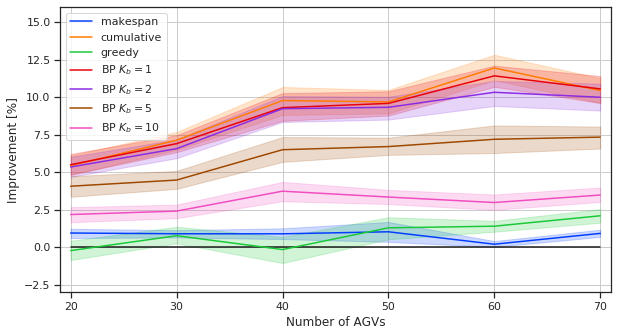

In [8]:
sns.set(style="ticks")
sns.set_palette("bright")
sns_col = sns.color_palette("bright", n_colors=7)

plt.figure()
plt.plot([20, 70],[0, 0],'k-')
g = sns.lineplot(x="AGVs", y="improvement",
             hue="cost_func",
             ci=64,
             data=df_actual_data,
             legend="full",
             palette=sns_col)
plt.ylim(-3, 16)
plt.xlabel("Number of AGVs")
plt.ylabel("Improvement [%]")
plt.xlim(19,71)
plt.grid(True)
ax = plt.gca()
legend = ax.legend(loc="upper left")
legend.texts[0].set_text("$J()$")
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles[1:], labels=labels[1:])
legend.texts[0].set_text("makespan")
legend.texts[1].set_text("cumulative")
legend.texts[2].set_text("greedy")
legend.texts[3].set_text("BP $K_b = 1$")
legend.texts[4].set_text("BP $K_b = 2$")
legend.texts[5].set_text("BP $K_b = 5$")
legend.texts[6].set_text("BP $K_b = 10$")
ax.figure.set_size_inches(9,4.5)
plt.subplots_adjust(left=0.14, bottom=0.11, right=0.99, top=0.99, wspace=None, hspace=None)

plt.savefig(save_loc + "cost_func_comparison.pdf", format="pdf", pad_inches=0.01, transparent=True)